In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians, degrees, cos, sin, asin, sqrt

from scipy.stats import hmean

# from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm as tqdm_t

from tqdm._tqdm_notebook import tqdm_notebook as tqdm

import feather

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM, Dropout

from pathlib import Path

import utm

from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import nearest_points

from multiprocessing import Pool

from matplotlib.colors import LogNorm

from sklearn.neighbors import KNeighborsRegressor

In [2]:
test_fraction = 4/5

In [3]:
messages = pd.read_csv("../../Trapeze_Data/first dump/VehicleMessages.csv", dtype={"isValid":float, "workCode":float,"tripCode":float}, parse_dates=[1], infer_datetime_format=True)


In [4]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code",
                                     "mean_durations_by_segment_code_and_hour",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'line_distance',
                                     'to_centre_dist',
                                     'direction_degrees',
                                     'rain',
                                     'median_durations_by_segment_code_and_hour_and_day',
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'date','workid',
                                     'actualArrival',
                                     'publicName',
                                     'segment_name',
                                     'prev_segment_code_1',
                                     'next_segment_code_1'
                                    ])
se = se.set_index(se.columns[0])

In [5]:
routes = pd.read_csv("../../Bournemouth GTFS/routes.csv")
shapes = pd.read_csv("../../Bournemouth GTFS/shapes.csv")
stops = pd.read_csv("../../Bournemouth GTFS/stops.txt").set_index('stop_id')
trips = pd.read_csv("../../Bournemouth GTFS/trips.txt")
performed_work = pd.read_csv("../../Trapeze_Data/first dump/PerformedWork.csv", parse_dates=[1])

In [6]:
# se['speed_mph'] = se['line_distance']*1000/se['segment_duration'] * 2.237

# se['speed_mph_baseline'] = se['line_distance']*1000/se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

# And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

In [7]:
se['prev_segment_name'] = se['prev_segment_code_1'].str[:-2]
se['next_segment_name'] = se['next_segment_code_1'].str[:-2]

In [8]:
trips_to_shapes_dict = {}

for route_id, route_group in trips.groupby('route_id'):
    matching_shapes = route_group.groupby('shape_id').first().index.values
    
    trips_to_shapes_dict[route_id] = matching_shapes


In [9]:
shapes_dict = {}

for shape_name, shape in tqdm(shapes.groupby('shape_id')):
    
    coords = np.empty((len(shape)+1, 2))
    
    for i, row in enumerate(shape[['latitude','longitude']].itertuples()):

        coords[i, :] = utm.from_latlon(row[1], row[2])[:2]
                        
    shapes_dict[shape_name] = LineString(coords)

          

In [10]:
segment_cache = {}

def find_length_by_name_route(segment_name, route_id, line_dist):
    
    line_dist = line_dist * 1000
    
    if segment_name in segment_cache:
        return segment_cache[segment_name]
    
    if type(route_id) == float:
        if np.isnan(route_id):
            
            segment_cache[segment_name] = line_dist
            
            return line_dist
    
    best_dist = np.inf
    lengths = []
    distances = []
    
    stop_codes = segment_name.split('_')

    try:
        stop_1_point = Point(utm.from_latlon(*stops.loc[stop_codes[0]][['stop_lat', 'stop_lon']].values)[:2])

        stop_2_point = Point(utm.from_latlon(*stops.loc[stop_codes[1]][['stop_lat', 'stop_lon']].values)[:2])
    except KeyError:
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    for shape_name in trips_to_shapes_dict[route_id]:

        shape = shapes_dict[shape_name]
        
        nearest_1 = nearest_points(shape, stop_1_point)[0]
        nearest_2 = nearest_points(shape, stop_2_point)[0]

        combined_dist = stop_1_point.distance(nearest_1) + stop_2_point.distance(nearest_2)
            
#         distances.append(combined_dist)
#         lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))

        # Find the cases where the points are close to the shape
        if (combined_dist) <= best_dist:
            best_dist = combined_dist
            
            distances.append(combined_dist)
            lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))
                
    if(best_dist >= 15):
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    # Take the mean of only those shapes where the points is very close to the shape
    new_length = np.mean(np.asarray(lengths)[np.asarray(distances) == best_dist])
    
    if (new_length == 0) | (new_length > 4000):
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    segment_cache[segment_name] = new_length

    return segment_cache[segment_name]

In [292]:
def find_length_by_geo_route(lat1, lon1, lat2, lon2, route_id, line_dist):
    
    # Try if line_dist < 20 just return line_dist...
    
    if line_dist == 0:
        return line_dist
    
    if type(route_id) == float:
        if np.isnan(route_id):
            
            return line_dist
    
    best_dist = np.inf
    lengths = []
    distances = []

    try: 
        stop_1_point = Point(utm.from_latlon(lat1, lon1)[:2])

        stop_2_point = Point(utm.from_latlon(lat2, lon2)[:2])
        
        shape_names = trips_to_shapes_dict[route_id]
        
        lengths = np.empty(len(shape_names))
        distances = np.empty(len(shape_names))
    
        for idx, shape_name in enumerate(shape_names):

            shape = shapes_dict[shape_name]

            nearest_1 = nearest_points(shape, stop_1_point)[0]
            nearest_2 = nearest_points(shape, stop_2_point)[0]
            
            distances[idx] = stop_1_point.distance(nearest_1) + stop_2_point.distance(nearest_2)
            lengths[idx] = np.abs(shape.project(nearest_1) - shape.project(nearest_2))
            
#             # Find the cases where the points are close to the shape
#             if (combined_dist) <= best_dist:
#                 best_dist = combined_dist
                
#                 distances.append(combined_dist)
#                 lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))

        best_dist = np.min(distances)
   
        # If the combined distance between the points and the best shape is over 10 meters
        # Or if the distance is more than a quater of the strieght line distance between the 
        # points just use the line distance.
        if (best_dist >= 10) or ((best_dist * 4) > line_dist):
            return line_dist

        # Take the mean of only those shapes where the points is very close to the shape
        new_length = np.mean(lengths[distances == best_dist])

    except: 
        return line_dist
    
    if (new_length == 0) | (new_length > line_dist*10) | (new_length < line_dist):
        
        return line_dist

    return new_length

In [12]:
se['route_id'] = routes.set_index('route_short_name').loc[se['publicName']]['route_id'].values


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [13]:
tqdm.pandas("My Bar")

In [14]:
se['real_length'] = se.progress_apply(lambda row: find_length_by_name_route(row['segment_name'], row['route_id'], row['line_distance']), axis=1)

In [180]:
se['speed_mph'] = se['real_length'] / se['segment_duration'] * 2.237

se['speed_mph_baseline'] = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

In [17]:
messages['timeReported'] = pd.to_datetime(messages['timeReported'])

In [ ]:
messages['delta_time'] = messages['timeReported'] - messages.shift(1)['timeReported']
messages['time_seconds'] = messages['delta_time'] / np.timedelta64(1, 's')

In [ ]:
messages['workCode'] = messages['workCode'].fillna(method="ffill")
messages['tripCode'] = messages['tripCode'].fillna(method="ffill")

In [ ]:
messages['dateReported'] = messages['timeReported'].dt.date

In [18]:
messages['dateReported'] = pd.to_datetime(messages['dateReported'])

In [ ]:
performed_work['tripCode'] = performed_work['tripCode'].replace([np.nan, np.inf], -1)

performed_work['tripCode'] = performed_work['tripCode'].astype(int)

In [ ]:
messages = messages.reset_index().merge(performed_work[['workCode', 'tripCode', 'date', 'publicName']],
                            left_on=['workCode', 'tripCode', 'dateReported'], 
                            right_on=['workCode', 'tripCode', 'date'],
                           how="left").set_index("index")

In [ ]:
messages = messages.drop(columns=['date_x', 'publicName_x'])

In [ ]:
messages = messages.reset_index().merge(routes[['route_short_name', 'route_id']], 
                                        left_on=['publicName'], 
                                        right_on=['route_short_name'], 
                                        how="left").set_index("index")

In [ ]:
plt.hist((messages['delta_time'] / np.timedelta64(1, 's')).values, bins=100, range=(-10, 300));
plt.yscale("log")
plt.show()

In [19]:
print(f"Fraction under 31 seconds: {np.count_nonzero(messages['time_seconds'] < 31)/messages.shape[0]}")
      
print(f"Between 20 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 20))/messages.shape[0]}")
      
print(f"Between 10 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 10))/messages.shape[0]}")
      
print(f"Between 5 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 5))/messages.shape[0]}")
      

Fraction under 31 seconds: 0.9922119130009464
Between 20 and 31 seconds: 0.49658042452244816
Between 10 and 31 seconds: 0.6831238955905359
Between 5 and 31 seconds: 0.817413135029027


In [ ]:
messages['delta_lon'] = messages['lon'] - messages.shift(1)['lon']
messages['delta_lat'] = messages['lat'] - messages.shift(1)['lat']

In [338]:
messages['msg'].unique()

array(['inPosition', 'InTripEnd', 'InTripStart', 'InPointArrive',
       'InPointDepart'], dtype=object)

In [20]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [21]:
messages['delta_distance'] = haversine_np(messages['lon'], messages['lat'], messages['lon'].shift(1), messages['lat'].shift(1)) * 1000


In [22]:
messages = messages.dropna(subset=['lon', 'lat'])

messages = messages[(messages['time_seconds'] > 0)]

In [ ]:
messages['lon_next'] = messages['lon'].shift(1)
messages['lat_next'] = messages['lat'].shift(1)


In [293]:
num_partitions = 20
num_cores = 5

def parallelize_dataframe(df, func, args):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    
    # This line is fidly, we make a list where each item is a tuple of 
    # a bit of the dataframe and whatever is passed in as args. 
    # Then starmap unpacks that tuple so each copy of func gets it's 
    # little bit of the dataframe and the right args to do it's job. 
    # All this to avoid globals! 
    all_args = [(split,) + args for split in df_split]
    
    df = pd.concat(pool.starmap(func, all_args))
    pool.close()
    pool.join()
    return df

In [294]:
messages.iloc[1510485]


index                                 1480394
vehicle                                   136
timeReported              2018-09-24 15:08:59
msg                                inPosition
lon                                  -1.88663
lat                                   50.7571
bearing                                     2
isValid                                     1
stopCode                                  NaN
workCode                                  502
tripCode                                  113
delta_time          0 days 00:00:18.000000000
time_seconds                               18
dateReported              2018-09-24 00:00:00
date                               2018-09-24
publicName                                  5
route_short_name                            5
route_id                      DOAO005:DOAO005
delta_lon                                   0
delta_lat                            0.000216
delta_distance                         24.003
lon_next                          

In [295]:
def find_dist(messages):

    messages['true_distance'] = messages[['lon', 'lat', 
                                          'lon_next', 'lat_next', 
                                          'route_id', 'delta_distance'
                                         ]].apply(lambda row: find_length_by_geo_route(*row[['lat', 'lon',
                                                                                          'lat_next', 
                                                                                           'lon_next',
                                                                                           'route_id',
                                                                                           'delta_distance'
                                                                                          ]]), axis=1)

    return messages



In [296]:
messages = parallelize_dataframe(messages, find_dist, ())

In [297]:
messages['delta_speed'] = messages['true_distance']/messages['time_seconds']

In [298]:
messages['speed_mph'] = messages['delta_speed'] * 2.237

In [16]:
# messages.to_csv("messages_with_true_dist.csv")

messages = pd.read_csv("messages_with_true_dist.csv")

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [299]:
messages.to_csv("messages_with_true_dist.csv")

In [300]:
print(f"total: {len(messages)}")

print(f"changed: {np.count_nonzero(messages['true_distance'] != messages['delta_distance'])}")
      
print(f"is close: {np.count_nonzero(np.isclose(messages['true_distance'], messages['delta_distance']))}")

total: 21434532
changed: 5660938
is close: 15777464


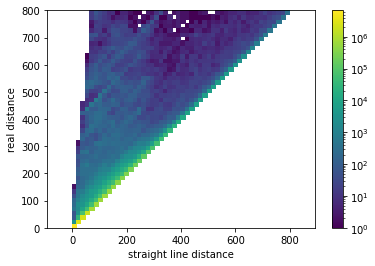

In [301]:
plt.hist2d(messages['delta_distance'], messages['true_distance'], bins=[50,50], range=[[0,800],[0,800]], norm=LogNorm())
plt.axis('equal')
plt.xlabel("straight line distance")
plt.ylabel("real distance")
plt.colorbar()

In [318]:
(np.count_nonzero(messages['delta_distance'] == messages['true_distance'])/len(messages))*100

73.58963564028363

total: 3920087
changed: 2764852
is close: 1155235


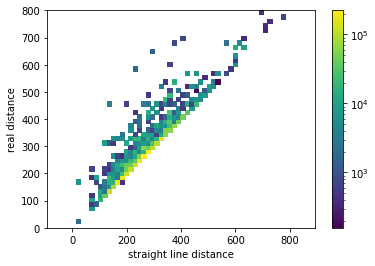

In [32]:
print(f"total: {len(se)}")

print(f"changed: {np.count_nonzero(se['real_length'] != se['line_distance']*1000)}")
      
print(f"is close: {np.count_nonzero(np.isclose(se['real_length'], se['line_distance']*1000))}")

plt.hist2d(se['line_distance']*1000, se['real_length'], bins=[50,50], range=[[0,800],[0,800]], norm=LogNorm())
plt.axis('equal')
plt.xlabel("straight line distance")
plt.ylabel("real distance")
plt.colorbar()

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


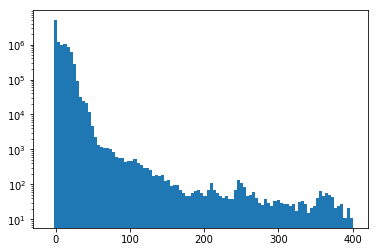

In [33]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400));
plt.yscale("log")

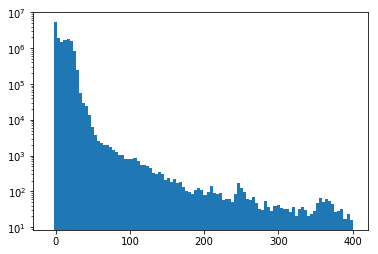

In [34]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400));
plt.yscale("log")

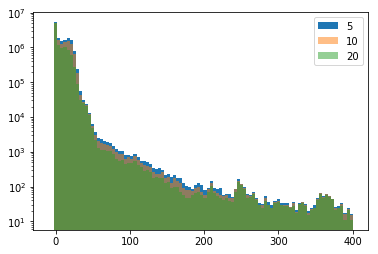

In [35]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400), label="5");
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 10)]['speed_mph'], bins=100, range=(-10,400), label="10", alpha=0.5);
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400), label="20", alpha=0.5);
plt.yscale("log")
plt.legend()

In [340]:
np.sum(messages[(messages['msg'].isin(['inPosition', 'InPointArrive']))]['time_seconds'])

431833852.0

In [343]:
np.sum(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['speed_mph'] < 3)]['time_seconds'])

226289342.0

In [345]:
226289342.0/431833852.0*100

52.40194601510768

In [36]:
messages['prev_speed_mph'] = messages.shift(1)['speed_mph']
messages['next_speed_mph'] = messages.shift(-1)['speed_mph']

In [37]:
messages['jitter'] = [False]*messages.shape[0]

messages['jitter'] = (messages['speed_mph'] > 75) & \
    (((messages['prev_speed_mph'] > 75) & (messages['next_speed_mph'] < 50)) | \
     ((messages['next_speed_mph'] > 75) & (messages['prev_speed_mph'] < 50)))

In [38]:
filtered = messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5) & (messages['jitter'] == False) & (messages['speed_mph'] != np.inf)]


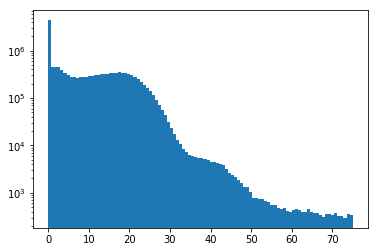

In [39]:
plt.hist(filtered['speed_mph'], bins=100, range=(0,75));
plt.yscale("log")

In [40]:
hourly_averages = filtered.groupby(filtered['timeReported'].dt.hour).mean()

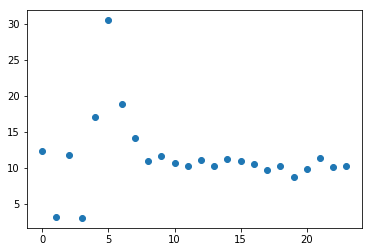

In [41]:
plt.scatter(hourly_averages.index, hourly_averages['speed_mph'])

In [42]:
filtered['segment_name'] = filtered['stopCode'].fillna(method="ffill") + "_" + filtered['stopCode'].fillna(method="bfill") 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
se['speed_mph'] = se['real_length']/se['segment_duration'] * 2.237

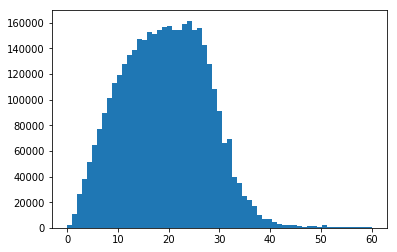

In [44]:
plt.hist(se['speed_mph'], range=(0, 60), bins=61);

In [45]:
se['mean_speed_mph_by_segment_code'] = se['real_length']/se['mean_durations_by_segment_code'] * 2.237

se['mean_speed_mph_by_segment_code_hour'] = se['real_length']/se['mean_durations_by_segment_code_and_hour'] * 2.237

se['speed_mph_diff_mean_to_hour'] = se['mean_speed_mph_by_segment_code_hour'] - se['mean_speed_mph_by_segment_code']


In [ ]:
just_one = se[se['arrival_day'] < 5].groupby(["segment_name", "arrival_hour"]).first()

In [ ]:
just_one = just_one.reset_index().merge(all_stats_df, left_on=['segment_name','arrival_hour'], right_on=['seg_name','hours']) # .set_index(['segment_name','arrival_hour'])

just_one = just_one.dropna(axis=0)

In [ ]:
data_to_fit = just_one[['slow_fraction', 'fast_mean', 'total_mean',
                        'clipped_hmean','clipped_mean','freq',
                        'fast_hmean', 'real_length', ]].values
#                         'direction_degrees', 'to_centre_dist']].values

poly = PolynomialFeatures(2)

expanded_data = poly.fit_transform(data_to_fit)

names = poly.get_feature_names(['slow_fraction', 'fast_mean', 'total_mean',
                                'clipped_hmean','clipped_mean','freq',
                                'fast_hmean','real_length', ])
                                #'direction_degrees', 'to_centre_dist'])


In [80]:
def prep_training_data(data, target, cut_point):

#     cut_point = int(len(data)*test_fraction)
    
    train_data = data[:cut_point,:]
    test_data = data[cut_point:,:]
    
    test_mask = np.zeros(data.shape[0]).astype(bool)
    test_mask[cut_point:] = True

    train_target = target[:cut_point]
    test_target = target[cut_point:]
    
    scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

#     scaler_target = preprocessing.MinMaxScaler().fit(train_target[:, None])


    train_target_scaled = scaler_target.transform(train_target[:, None]).astype(np.float32)
    test_target_scaled = scaler_target.transform(test_target[:, None]).astype(np.float32)
    
    data_scaler = preprocessing.StandardScaler()

    train_data_scaled = data_scaler.fit_transform(train_data).squeeze()
    test_data_scaled = data_scaler.transform(test_data).squeeze()

    return train_data_scaled, test_data_scaled, train_target_scaled, test_target_scaled, scaler_target


In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(expanded_data, just_one['mean_speed_mph_by_segment_code_hour'].values, int(len(expanded_data)*test_fraction))

test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

lr = LinearRegression()
# lr = Lasso()

lr.fit(train_data_scaled, train_target_scaled)

test_y_scaled = lr.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))


In [ ]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

ordered_coef = np.array(lr.coef_).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(expanded_data, just_one['mean_speed_mph_by_segment_code_hour'].values, int(len(expanded_data)*test_fraction))

ar = ARDRegression()
# lr = Lasso()

ar.fit(train_data_scaled, train_target_scaled)

test_y_scaled = ar.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))


In [ ]:
test_y_scaled = ar.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)


In [ ]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(ar.coef_))].squeeze()

ordered_coef = np.array(ar.coef_).squeeze()[np.argsort(np.abs(ar.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

In [85]:
def create_simple_model(input_shape, dropout, NN, use_linear):

    # with help from: https://keras.io/getting-started/functional-api-guide/

    # Headline input: meant to receive road time series.
    main_input = Input(shape=[input_shape], dtype="float32", name="input")

    for index, layer in enumerate(NN):
        if(index == 0):
            x = Dense(layer, activation="relu")(main_input)
            x = Dropout(rate=dropout)(x)
        else:
            x = Dense(layer, activation="relu")(x)
            x = Dropout(rate=dropout)(x)

#     # We stack a deep densely-connected network on top
#     x = Dense(128, activation="relu")(main_input)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(64, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(12, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)

    # And finally we add the main output layer
    if use_linear:
        main_output = Dense(1, activation="linear", name="main_output")(x)
    else: 
        main_output = Dense(1, activation="tanh", name="main_output")(x)

    model = Model(
        inputs=[main_input], outputs=[main_output]
    )

    model.summary()

    return model

In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(data_to_fit, just_one['mean_speed_mph_by_segment_code_hour'], int(len(data_to_fit)*test_fraction))

model = create_simple_model(
        (train_data_scaled.shape[1]),
        0.1)

Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath=f"GPS_models/simple.h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

# model.compile(optimizer="rmsprop", loss="mean_absolute_error")
model.compile(optimizer="rmsprop", loss="mse")
model.fit(
    train_data_scaled,
    train_target_scaled,
    epochs=100,
    callbacks=callbacks_list,
    batch_size=32,
    validation_data=(test_data_scaled, test_target_scaled),
)

test_y_scaled = model.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

In [ ]:
test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

### Plan

- Calc the stats for all the segments
- Load up the means by hour of the day and daytype for each of these segment names
- Try to find a way to predict the spead of the segment by hour using the stats
- Get the stats for each indivual event, not just the bulk averages, 
    - Do the same for the last hour on that segment and think about fast ways to do prev/next as well
- Try to find the stats with the highest and lowest variance (forcus on those with lower variance)
- See if you can then find outliers... 
- Is there enough data? 

In [319]:
segments_dict = {}

segments = filtered.groupby('segment_name')

for seg_name, segment in segments:
    
     df = segment.set_index("timeReported")['speed_mph']
        
     df.index = pd.to_datetime(df.index)
    
     segments_dict[seg_name] = df

In [323]:
matrix_width = 16

In [324]:
se_gps_data_hour = np.zeros((se.shape[0], matrix_width)).astype(np.float32)
se_gps_data_20mins = np.zeros((se.shape[0], matrix_width)).astype(np.float32)

In [325]:
se_gps_data_hour_prev_next = np.zeros((se.shape[0], matrix_width)).astype(np.float32)

In [326]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values
    
    if(len(relevant) == 0):
        se_gps_data_hour[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)

    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)
    row_data[15] = np.std(fast)
    
    se_gps_data_hour[idx, :] = row_data


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/scipy/stats/stats.py:377: RuntimeWarning: invalid value encountered in double_scalars
  return size / np.sum(1.0 / a, axis=axis, dtype=dtype)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encoun

In [327]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"40 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values
    
    if(len(relevant) == 0):
        se_gps_data_20mins[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)
    
    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)
    row_data[15] = np.std(fast)

    
    se_gps_data_20mins[idx, :] = row_data
    

In [328]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name', 'prev_segment_name', 'next_segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant_current = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()
    
    if (row[3] != '') & (row[3] in segments_dict):
        gps_tracks_prev = segments_dict[row[3]]
        
        relevant_prev = gps_tracks_prev[(gps_tracks_prev.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks_prev.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()
    else:
        relevant_prev = [] 
        
    if (row[4] != '') & (row[4] in segments_dict):
        gps_tracks_next = segments_dict[row[4]]
    
        relevant_next = gps_tracks_next[(gps_tracks_next.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks_next.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()   
    else: 
        relevant_next = []
    
    relevant = np.concatenate(np.atleast_1d(relevant_current, relevant_prev, relevant_next))
    
    if(len(relevant) == 0):
        se_gps_data_hour_prev_next[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)
    
    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)
    row_data[15] = np.std(fast)
    
    se_gps_data_hour_prev_next[idx, :] = row_data
    

In [329]:
np.save("se_gps_features_20min_80min_5", se_gps_data_hour)
np.save("se_gps_features_20min_40min_5", se_gps_data_20mins)

In [330]:
np.save("se_gps_features_20min_80min_prev_next_5", se_gps_data_hour_prev_next)

In [81]:
# se_gps_data_hour = np.load("se_gps_features_20min_80min_4.npy")
# se_gps_data_20mins = np.load("se_gps_features_20min_40min_4.npy", )


In [ ]:
# se_gps_data_hour_prev_next = np.load("se_gps_features_20min_80min_prev_next_4.npy")

In [209]:
data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
                                                            'direction_degrees', 
                                                            "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day']].values))

df_cors = pd.DataFrame(data=np.hstack((data, se[['speed_mph']].values)),
                    columns=['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                'clipped_hmean','clipped_mean','freq_total',
                                'freq_fast','freq_clipped', 
                               'fast_median', 'fast_75th percential',
                              'total_median', 'total_75th percential', 'max', 
                             'real_length', 'direction_degrees', "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day','true_speed'])

cors = df_cors[df_cors['freq_fast'] >= 10].corr()

In [210]:
cors

,slow_fraction,fast_hmean,fast_mean,total_mean,clipped_hmean,clipped_mean,freq_total,freq_fast,freq_clipped,fast_median,...,total_median,total_75th percential,max,real_length,direction_degrees,to_centre_dist,rain,arrival_hour,arrival_day,true_speed
slow_fraction,1.000000,-0.085086,-0.015918,-0.123218,-0.293190,-0.348130,0.410434,-0.039840,-0.040917,-0.155339,...,-0.824777,-0.726113,0.005793,0.063849,-0.067623,0.058054,-0.009628,-0.079597,-0.009654,-0.143314
fast_hmean,-0.085086,1.000000,0.191173,0.066436,0.997656,0.878331,-0.053959,-0.026819,-0.028752,0.954215,...,0.196064,0.197417,0.009068,0.025335,-0.008066,-0.013879,0.004772,-0.020408,0.007655,0.039653
fast_mean,-0.015918,0.191173,1.000000,0.947600,0.057489,0.063775,-0.014139,-0.010551,-0.012872,0.188045,...,0.040582,0.049386,0.889931,0.004667,0.000635,0.019136,0.003057,-0.015147,0.001953,0.009046
total_mean,-0.123218,0.066436,0.947600,1.000000,0.095542,0.107891,-0.059918,-0.007812,-0.009812,0.083182,...,0.136825,0.133548,0.871354,-0.002376,0.007580,0.010585,0.002354,-0.008328,0.003095,0.025601
clipped_hmean,-0.293190,0.997656,0.057489,0.095542,1.000000,0.880151,-0.191941,-0.086565,-0.087540,0.815515,...,0.648068,0.656905,-0.005484,0.077025,-0.020571,-0.044919,0.017330,-0.058246,0.021313,0.130196
clipped_mean,-0.348130,0.878331,0.063775,0.107891,0.880151,1.000000,-0.263631,-0.138128,-0.139184,0.924235,...,0.666249,0.802281,-0.007436,0.086591,-0.057134,0.003527,0.013161,-0.071405,0.010294,0.180924
freq_total,0.410434,-0.053959,-0.014139,-0.059918,-0.191941,-0.263631,1.000000,0.837911,0.836356,-0.113460,...,-0.358897,-0.387339,0.010874,0.168965,-0.152392,-0.124589,-0.020842,-0.047480,-0.022471,-0.158576
freq_fast,-0.039840,-0.026819,-0.010551,-0.007812,-0.086565,-0.138128,0.837911,1.000000,0.999577,-0.058020,...,-0.008812,-0.049268,0.008275,0.133137,-0.155185,-0.226237,-0.022756,-0.021580,-0.030730,-0.102790
freq_clipped,-0.040917,-0.028752,-0.012872,-0.009812,-0.087540,-0.139184,0.836356,0.999577,1.000000,-0.059782,...,-0.008558,-0.049394,0.006368,0.131477,-0.154205,-0.227161,-0.022727,-0.021260,-0.030227,-0.102596
fast_median,-0.155339,0.954215,0.188045,0.083182,0.815515,0.924235,-0.113460,-0.058020,-0.059782,1.000000,...,0.311960,0.377304,0.006589,0.025814,-0.015599,-0.014406,0.005824,-0.038591,0.007625,0.081327


In [132]:
# For version 3

cors['true_speed'].abs().sort_values().index[::-1]

Index(['true_speed', 'total_75th percential', 'total_median', 'clipped_mean',
       'slow_fraction', 'fast_median', 'fast_75th percential', 'freq_total',
       'clipped_hmean', 'fast_hmean', 'real_length', 'freq_fast',
       'freq_clipped', 'total_mean', 'direction_degrees', 'fast_mean', 'max'],
      dtype='object')

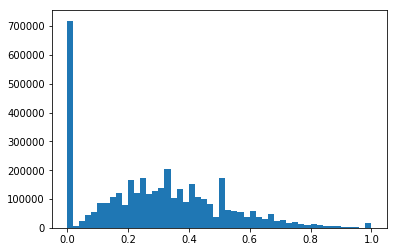

In [278]:
plt.hist(se_gps_data_hour_prev_next[:,1], bins=50, range=(0,1));

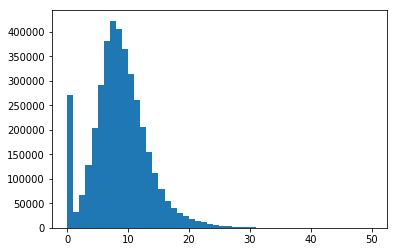

In [279]:
plt.hist(se_gps_data_hour_prev_next[:,4], bins=50, range=(0,50));

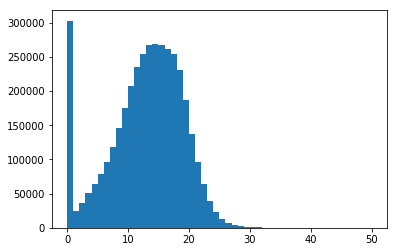

In [63]:
plt.hist(se_gps_data_hour_prev_next[:,13], bins=50, range=(0,50));

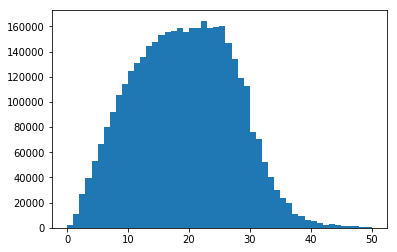

In [64]:
plt.hist(se['speed_mph'], bins=50, range=(0,50));

(0.0, 50.0, 0.0, 30.0)

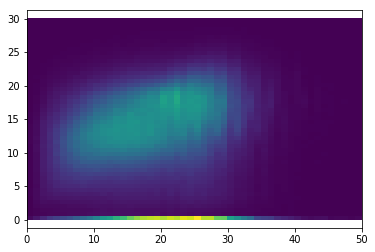

In [281]:
plt.hist2d(se['speed_mph'], se_gps_data_hour_prev_next[:,13], range=[[0,50],[0,30]], bins=[50,50]);
plt.axis('equal')

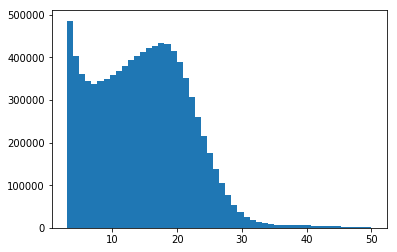

In [66]:
plt.hist(filtered['speed_mph'], bins=50, range=(3,50));

In [67]:
def make_valid_mask(freq):

    valid_mask = (se_gps_data_hour_prev_next[:,9] >= freq) & \
    (se['speed_mph'] != np.inf) & \
    (~np.isnan(se_gps_data_hour_prev_next[:,4])) & \
    (~np.isnan(se_gps_data_hour_prev_next[:,10])) & \
    (se_gps_data_hour_prev_next[:,13] != 0)
    
    return valid_mask

In [ ]:
# def do_baselines(valid_mask):
#     (baseline_array_cum, 
#      actual_array_cum, 
#      baseline_median_array_cum, 
#      baseline_pass_count, 
#      pass_fraction, 
#      baseline_median_pass_count, 
#      median_pass_fraction) =  calc_baseline_and_actual(se[int(len(se)*test_fraction):])

#     return (baseline_array_cum, 
#          actual_array_cum, 
#          baseline_median_array_cum, 
#          baseline_pass_count, 
#          pass_fraction, 
#          baseline_median_pass_count, 
#          median_pass_fraction)

# calc_baseline_and_actual

In [68]:
# 0 slow_fraction
# 1 fast_hmean
# 2 fast_mean
# 3 total_mean
# 4 clipped_hmean
# 5 clipped_mean
# 6 freq_total
# 7 freq_fast
# 8 freq_clipped
# 9 fast_median
# 10 fast_75th percential
# 11 total_median
# 12 total_75th percential
# 13 max

overlaps_dict = {}
overlaps_dict[0] = []
overlaps_dict[1] = [4, 5, 11, 9, 12]
overlaps_dict[2] = [3, 10, 9]
overlaps_dict[3] = [2, 10, 12]
overlaps_dict[4] = [1, 5]
overlaps_dict[5] = [1, 4]
overlaps_dict[6] = [7, 8]
overlaps_dict[7] = [6, 8]
overlaps_dict[8] = [6, 7]
overlaps_dict[9] = [1, 2, 10, 12]
overlaps_dict[10] = [2, 9, 3]
overlaps_dict[11] = [1, 12]
overlaps_dict[12] = [1, 3, 9, 11]
overlaps_dict[13] = []
overlaps_dict[14] = []
overlaps_dict[15] = []


In [69]:
def make_overlap_mask(width = 17):
    overlaps_mask = np.zeros(width)

    overlaps_mask[:] = -1
    
    overlaps_mask[11] = 1 # 11 total_median
    overlaps_mask[4] = 1 # 4 clipped_hmean
    overlaps_mask[3] = 1 # 3 total_mean
    
    while(np.isin([-1], overlaps_mask).any()):
        options = np.where(overlaps_mask < 0)[0]
    #     print(options)
        i = np.random.randint(len(options))
#         print(i)
        overlaps_mask[options[i]] = 1
        overlaps_mask[overlaps_dict[options[i]]] = 0

    return overlaps_mask.astype(bool)
    


In [222]:
def best_overlap_mask(freq, data, columns):
    
#     data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
#                                                             'direction_degrees', 
#                                                             "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day']].values))

    df_cors = pd.DataFrame(data=np.hstack((data, se[['speed_mph']].values)),
                        columns=columns)

    cors = df_cors[df_cors['freq_fast'] >= freq].corr()
    
    overlaps_dict = {}

    abs_cor_top_75th = np.percentile(np.abs(cors.values), 75)

    for col_idx, column in enumerate(cors.columns):

        if column == 'true_speed':
            continue

        overlaps_dict[column] = []

        for row_idx, (name, value) in enumerate(cors[column].iteritems()):
            if np.abs(value) > abs_cor_top_75th and column != name:
    #             print(f"{column} -> {name}: {value}")
                overlaps_dict[column].append(row_idx)
        
    overlap_mask = np.empty(len(cors['true_speed']))

    overlap_mask[:] = -1

    for best in cors['true_speed'].abs().sort_values().index[::-1]:

        if(best == "true_speed"):
            continue

        best_idx = cors.columns.get_loc(best)

        if overlap_mask[best_idx] == -1:
            overlap_mask[best_idx] = 1
            overlap_mask[overlaps_dict[best]] = 0


    return overlap_mask[:-1]

In [199]:
train_speeds = se['speed_mph'][:int(len(se)*test_fraction)]

mean_speed = np.mean(train_speeds[np.isfinite(train_speeds)])
print(mean_speed)

19.93434555257848


In [200]:
(baseline_array_cum, 
     actual_array_cum, 
     baseline_median_array_cum, 
     baseline_pass_count, 
     pass_fraction, 
     baseline_median_pass_count, 
     median_pass_fraction) = calc_baseline_and_actual(se[int(len(se)*test_fraction):])

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


In [331]:
def learn(freq, dropout, loss, NN, use_linear = False):
    
    valid_mask = make_valid_mask(freq)
    
#     data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
#                                                             'direction_degrees', 
#                                                             "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day'
#                                                            ]].values))

#     overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
#                                     'clipped_hmean','clipped_mean','freq_total',
#                                     'freq_fast','freq_clipped', 
#                                    'fast_median', 'fast_75th percential',
#                                   'total_median', 'total_75th percential', 'max', 
#                                  'real_length', 'direction_degrees', "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day','true_speed'])


    data = se_gps_data_hour_prev_next[:,1:]

    overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                    'clipped_hmean','clipped_mean','freq_total',
                                    'freq_fast','freq_clipped', 
                                   'fast_median', 'fast_75th percential',
                                  'total_median', 'total_75th percential', 'max','std', 
                                    'true_speed'])

    
    # where on the reduced (valid mask) data is the right place to cut so that when it comes back
    # it's exactly test_fraction from the start
    cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    
#     speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237
    
#     (train_data_scaled, test_data_scaled, 
#      train_target_scaled_baseline, test_target_scaled_baseline, 
#      scaler_target_baseline) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], speeds_mph_simple[valid_mask], cut_point_valid)


    (train_data_scaled, test_data_scaled, 
     train_target_scaled, test_target_scaled, 
     scaler_target) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], se[valid_mask]['speed_mph'], cut_point_valid)

    print(overlaps_mask)
    
    model = create_simple_model(
            (train_data_scaled.shape[1]),
            dropout, NN, use_linear)

    Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"GPS_models/freq_{freq}_mask_{overlaps_mask}_simple_[{'_'.join(list(map(str, NN)))}]_{loss}_{dropout}_{use_linear}.h5",
            monitor="val_loss",
            save_best_only=True,
        ),
    ]

    # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
#     model.compile(optimizer="rmsprop", loss="logcosh")
    model.compile(optimizer="rmsprop", loss=loss)
    model.fit(
        train_data_scaled,
        train_target_scaled,
        epochs=100,
        callbacks=callbacks_list,
        batch_size=256,
        validation_data=(test_data_scaled, test_target_scaled),
    )

    test_y_scaled = model.predict(test_data_scaled)

    test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

    test_y[valid_mask[int(len(se)*test_fraction):]] = scaler_target.inverse_transform(test_y_scaled)
    
    test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
    test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

    RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
    MAE = mean_absolute_error(test_target_truth, test_y)
    
    print(f"RMSE pred: {np.sqrt(mean_squared_error(test_target_truth, test_y))}")
    print(f"RMSE base: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")
    print(f"RMSE base_median: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")

    print(f"MAE pred: {mean_absolute_error(test_target_truth, test_y)}")
    print(f"MAE base: {mean_absolute_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    print(f"MAE base_median: {mean_absolute_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    
    predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

    return overlaps_mask, pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum

In [332]:
def learn_KNN(freq=10, k=5):
    
    valid_mask = make_valid_mask(freq)
    
    data = se_gps_data_hour_prev_next[:,1:]

    overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                    'clipped_hmean','clipped_mean','freq_total',
                                    'freq_fast','freq_clipped', 
                                   'fast_median', 'fast_75th percential',
                                  'total_median', 'total_75th percential', 'max', 'std', 
                                    'true_speed'])

    
    # where on the reduced (valid mask) data is the right place to cut so that when it comes back
    # it's exactly test_fraction from the start
    cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    
#     speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237
    
#     (train_data_scaled, test_data_scaled, 
#      train_target_scaled_baseline, test_target_scaled_baseline, 
#      scaler_target_baseline) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], speeds_mph_simple[valid_mask], cut_point_valid)


    (train_data_scaled, test_data_scaled, 
     train_target_scaled, test_target_scaled, 
     scaler_target) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], se[valid_mask]['speed_mph'], cut_point_valid)

    neigh = KNeighborsRegressor(n_neighbors=k, weights="distance")
    neigh.fit(train_data_scaled, train_target_scaled) 

    test_y_scaled = neigh.predict(test_data_scaled)

    test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

    test_y[valid_mask[int(len(se)*test_fraction):]] = scaler_target.inverse_transform(test_y_scaled)
    
    test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
    test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

    RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
    MAE = mean_absolute_error(test_target_truth, test_y)
    
    print(f"RMSE pred: {np.sqrt(mean_squared_error(test_target_truth, test_y))}")
    print(f"RMSE base: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")
    print(f"RMSE base_median: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")

    print(f"MAE pred: {mean_absolute_error(test_target_truth, test_y)}")
    print(f"MAE base: {mean_absolute_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    print(f"MAE base_median: {mean_absolute_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")

    
    predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

    return overlaps_mask, pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum

In [334]:
_, _, _, _, test_y, predict_array_KNN_cum = learn_KNN(10, 5)

RMSE pred: 12.642925292262644
RMSE base: 11.617530348303768
RMSE base_median: 11.255640608723144
MAE pred: 6.366361400132681
MAE base: 5.130943291932916
MAE base_median: 4.596063341390417


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -14.08% improvment on baseline
Approximately 33.63% are in 10%


In [335]:
_, _, _, _, test_y, predict_array_NN_cum = learn(10, 0.0, "logcosh", [64,32,12], False)

# Draw real vs streight length for messages - Yes
# Try using straight lengths for the messages instead - Bad
# Try using a linear instead of tanh activation for the last layer - Worse
# Try predicting the mean and then still testing against true, for various networks
# Try to find one bus route where this works really well

[0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_273 (Dense)            (None, 64)                320       
_________________________________________________________________
dropout_273 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_274 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_274 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_275 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_275 (Dropout)        

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -16.43% improvment on baseline
Approximately 32.72% are in 10%


In [197]:
with open("GPS_run_3.csv", "a+") as f: 
    f.write("freq_threshold,dropout,loss,overlap_mask,NN,use_linear,pass_fraction,RMSE,MAE\n")
    for runs in range(5):
        for dropout in [0,0.2,0.5]:
            for loss in ['logcosh', 'mean_absolute_error', 'mean_squared_error']:
                for NN in [[64,32,12]]: #[[32,12,6], [64,32,12], [128,64,32,32,12]]:
                    for freq in [3,10,15,25]:
                        for use_linear in [True, False]:
                    
                            overlaps_mask, pass_fraction, RMSE, MAE, test_y = learn(freq, dropout, loss, NN, use_linear)
                            f.write(f"{freq},{dropout},{loss},{'_'.join(list(map(str,overlaps_mask)))},{'_'.join(list(map(str,NN)))},{use_linear},{pass_fraction},{RMSE},{MAE}\n")
                            f.flush()

[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 64)                448       
_________________________________________________________________
dropout_73 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_74 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 12)                396       
_________________________________________________________________
dropout_75 (Dropout)      

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -14.08% improvment on baseline
Approximately 33.64% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)                448       
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_77 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -15.42% improvment on baseline
Approximately 33.11% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_79 (Dense)             (None, 64)                448       
_________________________________________________________________
dropout_79 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_80 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -7.25% improvment on baseline
Approximately 36.31% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_82 (Dense)             (None, 64)                448       
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_83 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -9.69% improvment on baseline
Approximately 35.35% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 64)                448       
_________________________________________________________________
dropout_85 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_86 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -1.97% improvment on baseline
Approximately 38.38% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_88 (Dense)             (None, 64)                448       
_________________________________________________________________
dropout_88 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_89 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -5.11% improvment on baseline
Approximately 37.15% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_91 (Dense)             (None, 64)                384       
_________________________________________________________________
dropout_91 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_92 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -0.48% improvment on baseline
Approximately 38.96% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_94 (Dense)             (None, 64)                384       
_________________________________________________________________
dropout_94 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_95 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -0.04% improvment on baseline
Approximately 39.13% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_97 (Dense)             (None, 64)                448       
_________________________________________________________________
dropout_97 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_98 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -5.19% improvment on baseline
Approximately 37.12% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_100 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_101 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -4.74% improvment on baseline
Approximately 37.29% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_103 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_103 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_104 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -2.43% improvment on baseline
Approximately 38.20% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_106 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_106 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_107 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -6.24% improvment on baseline
Approximately 36.71% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_109 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_109 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_110 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -4.80% improvment on baseline
Approximately 37.27% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_112 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_112 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_113 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -3.47% improvment on baseline
Approximately 37.79% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_115 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_115 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_116 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -0.46% improvment on baseline
Approximately 38.97% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_118 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_118 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_119 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -0.64% improvment on baseline
Approximately 38.90% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_121 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_121 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_122 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -15.68% improvment on baseline
Approximately 33.01% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_124 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_124 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_125 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_125 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_126 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -16.41% improvment on baseline
Approximately 32.73% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_127 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_127 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_128 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -8.28% improvment on baseline
Approximately 35.91% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_130 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_130 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_131 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -3.05% improvment on baseline
Approximately 37.96% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_133 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_133 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_134 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -2.05% improvment on baseline
Approximately 38.35% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_136 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_136 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_137 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -4.58% improvment on baseline
Approximately 37.36% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_139 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_139 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_140 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -1.42% improvment on baseline
Approximately 38.59% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_142 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_142 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_143 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -1.04% improvment on baseline
Approximately 38.74% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_145 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_145 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_146 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_146 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -24.59% improvment on baseline
Approximately 29.52% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_148 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_148 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_149 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_150 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -23.78% improvment on baseline
Approximately 29.84% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_151 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_151 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_152 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_153 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -12.78% improvment on baseline
Approximately 34.14% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_154 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_154 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_155 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_155 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -12.12% improvment on baseline
Approximately 34.40% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_157 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_157 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_158 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -7.41% improvment on baseline
Approximately 36.25% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_160 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_160 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_161 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_162 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -6.49% improvment on baseline
Approximately 36.61% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_163 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_163 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_164 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_165 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -0.86% improvment on baseline
Approximately 38.81% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_166 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_166 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_167 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_167 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_168 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -1.49% improvment on baseline
Approximately 38.56% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_169 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_169 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_170 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_170 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_171 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -22.34% improvment on baseline
Approximately 30.40% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_172 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_172 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_173 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_173 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_174 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -18.01% improvment on baseline
Approximately 32.10% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_175 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_175 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_176 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -8.55% improvment on baseline
Approximately 35.80% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_178 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_178 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_179 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_179 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_180 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -7.40% improvment on baseline
Approximately 36.25% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_181 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_181 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_182 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_182 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_183 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -6.26% improvment on baseline
Approximately 36.70% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_184 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_184 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_185 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -3.79% improvment on baseline
Approximately 37.67% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_187 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_187 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_188 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_188 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_189 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -1.11% improvment on baseline
Approximately 38.71% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_190 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_190 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_191 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_191 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_192 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -0.86% improvment on baseline
Approximately 38.81% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_193 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_193 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_194 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_194 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_195 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -23.38% improvment on baseline
Approximately 29.99% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_196 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_196 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_197 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_197 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -25.61% improvment on baseline
Approximately 29.12% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_199 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_199 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_200 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_200 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_201 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -23.41% improvment on baseline
Approximately 29.98% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_202 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_202 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_203 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_203 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_204 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -15.84% improvment on baseline
Approximately 32.95% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_205 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_205 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_206 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_206 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_207 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -13.85% improvment on baseline
Approximately 33.72% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_208 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_208 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_209 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_209 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_210 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -10.29% improvment on baseline
Approximately 35.12% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_211 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_211 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_212 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_212 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_213 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -1.66% improvment on baseline
Approximately 38.50% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_214 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_214 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_215 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_215 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_216 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -1.85% improvment on baseline
Approximately 38.42% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_217 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_217 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_218 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_218 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_219 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -23.95% improvment on baseline
Approximately 29.77% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_220 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_220 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_221 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_222 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -26.39% improvment on baseline
Approximately 28.82% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_223 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_223 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_224 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_224 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_225 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -17.47% improvment on baseline
Approximately 32.31% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_226 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_226 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_227 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_227 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_228 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -14.05% improvment on baseline
Approximately 33.65% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_229 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_229 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_230 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_230 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_231 (Dense)            (None, 12)                396       
_______________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -9.36% improvment on baseline
Approximately 35.49% are in 10%
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_232 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_232 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_233 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_234 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -9.38% improvment on baseline
Approximately 35.48% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_235 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_235 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_236 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_236 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_237 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -3.01% improvment on baseline
Approximately 37.97% are in 10%
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_238 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_238 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_239 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_239 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_240 (Dense)            (None, 12)                396       
________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -2.17% improvment on baseline
Approximately 38.30% are in 10%
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_241 (Dense)            (None, 64)                448       
_________________________________________________________________
dropout_241 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_242 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_242 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_243 (Dense)            (None, 12)                396       
________________

KeyboardInterrupt: 


..............................................................................
..............................................................................
..............................................................................
..............................................................................

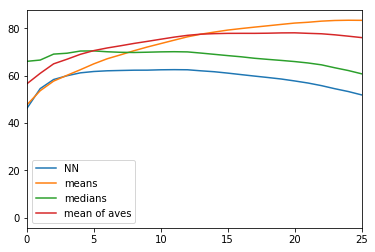

In [290]:
plt.plot(make_accuracy_matrix_minutes(predict_array_KNN_cum, actual_array_cum)[0][1,:], label="NN")
plt.plot(make_accuracy_matrix_minutes(baseline_array_cum, actual_array_cum)[0][1,:], label="means")
plt.plot(make_accuracy_matrix_minutes(baseline_median_array_cum, actual_array_cum)[0][1,:], label="medians")
plt.plot(make_accuracy_matrix_minutes((baseline_median_array_cum + baseline_array_cum)/2, actual_array_cum)[0][1,:], label="mean of aves")
plt.xlim(0,25)
plt.legend()
plt.show()

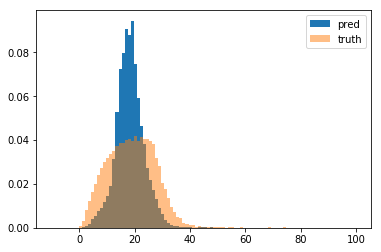

In [275]:
plt.hist(test_y, bins=100, label="pred", density=True, range=(-10,100));
plt.hist(se['speed_mph'][int(len(se)*test_fraction):], bins=100, label="truth", alpha=0.5, density=True, range=(-10,100));
plt.legend()

In [249]:
speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

se_min = se[['speed_mph', 'publicName', 'to_centre_dist', 'real_length', 'mean_durations_by_segment_code_and_hour_and_day']][int(len(se)*test_fraction):].copy()

se_min['baseline_speed'] = se_min['real_length'] / se_min['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

se_min['test_y'] = test_y

routes = []
pred_MSE = []
pred_RMSE = []
base_MSE = []
base_RMSE = []
freq = []
mean_dist = []

for route_name, route in se_min.groupby('publicName'):
    
    if route_name in schools:
        continue
        
    routes.append(route_name)
    pred_MSE.append(mean_absolute_error(route['speed_mph'], route['test_y']))
    pred_RMSE.append(np.sqrt(mean_squared_error(route['speed_mph'], route['test_y'])))
    base_MSE.append(mean_absolute_error(route['speed_mph'], route['baseline_speed']))
    base_RMSE.append(np.sqrt(mean_squared_error(route['speed_mph'], route['baseline_speed'])))
    freq.append(len(route))
    
results = pd.DataFrame(index=routes)
results['pred_MSE'] = pred_MSE
results['base_MSE'] = base_MSE
results['pred_RMSE'] = pred_RMSE
results['base_RMSE'] = base_RMSE
results['freq'] = freq

In [250]:
results.sort_values('pred_RMSE')

,pred_MSE,base_MSE,pred_RMSE,base_RMSE,freq
1b,5.111782,4.777915,8.201220,7.976357,54397
737,5.284352,4.984617,8.264765,8.018248,6941
2,5.331070,4.666555,9.196559,8.734662,61404
3,5.446466,4.811229,9.232296,8.882813,97389
33,5.740256,5.578338,9.729141,9.620281,17038
1,5.446122,4.956181,10.275780,10.004318,115007
36,5.748263,5.659710,10.729461,10.674614,9857
1c,5.732682,5.242936,12.043583,11.813066,55797
5,5.243633,4.856322,12.067818,11.939324,64973
18,4.593243,4.281359,12.195940,12.040658,19860


In [237]:
schools = ['46', '50', '60', '81', '85', '86', '87', '87A', '88', '111']

In [239]:
np.count_nonzero(se['publicName'].isin(schools))

24063

In [ ]:
# test_target_truth = se['speed_mph'][int(len(se[valid_mask])*test_fraction):]

test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.hist2d(test_target_truth, test_y.squeeze(), range=[[0,30],[0,30]], bins=[30,30])
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)
plt.axis('equal')

In [ ]:
predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[valid_mask][int(len(se[valid_mask])*test_fraction):], test_y.squeeze(), baseline_array_cum, actual_array_cum)
  

In [232]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0, 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))
    
    print("")

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [73]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [188]:
def calc_baseline_and_actual(data):
    
    se_min = data.copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    baseline_median_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_median_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")
    baseline_median_index = se_min.columns.get_loc("median_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])
        baseline_median_array[run.index,:] = create_triangle(run.iloc[:, baseline_median_index])
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    baseline_median_array_cum = np.cumsum(baseline_median_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = baseline_pass_count/np.count_nonzero(first_20mins_mask)
    
    baseline_median_pass_count = np.count_nonzero((baseline_median_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_median_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    median_pass_fraction = baseline_median_pass_count/np.count_nonzero(first_20mins_mask)
    
    return baseline_array_cum, actual_array_cum, baseline_median_array_cum, baseline_pass_count, pass_fraction, baseline_median_pass_count, median_pass_fraction


In [189]:
def calc_prediction_cum_journeys(data, speeds_mph, baseline_array_cum, actual_array_cum):
    
    se_min = data.copy()
      
    se_min['prediction'] = se_min['real_length'] / speeds_mph * 2.237
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])
     
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    

In [165]:
a = pd.DataFrame(data=[[1,2],[3,4],[5,6]], columns=['a','b'])

In [166]:
a

,a,b
0,1,2
1,3,4
2,5,6


In [167]:
b = a[1:].copy()

In [168]:
b

,a,b
1,3,4
2,5,6


In [169]:
b['c'] = a['a']

In [170]:
b

,a,b,c
1,3,4,3
2,5,6,5
